In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

***
## __Initial Read-in and Dataset Observation__
***

In [31]:
# Options to allow me to see every attribute in this dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read the dataset in
df = pd.read_csv("D:\\School\\Summer_2019\\HousingPriceCompetition\\house-prices-advanced-regression-techniques\\train.csv")

# Display the top values of the dataset
df.head()

# Shape of the design matrix showing that there are 81 attributes (not yet accounting for the fact that one is id) and 1460 observations
print(df.shape)

# Display the data type of each attribute.
# df.dtypes

# Observation indicates several qualitative variables which must be OneHotEncoded in order to be properly studied.
#df.dtypes[[0][0]] # This code allows for extraction of each individual data type.

(1460, 81)


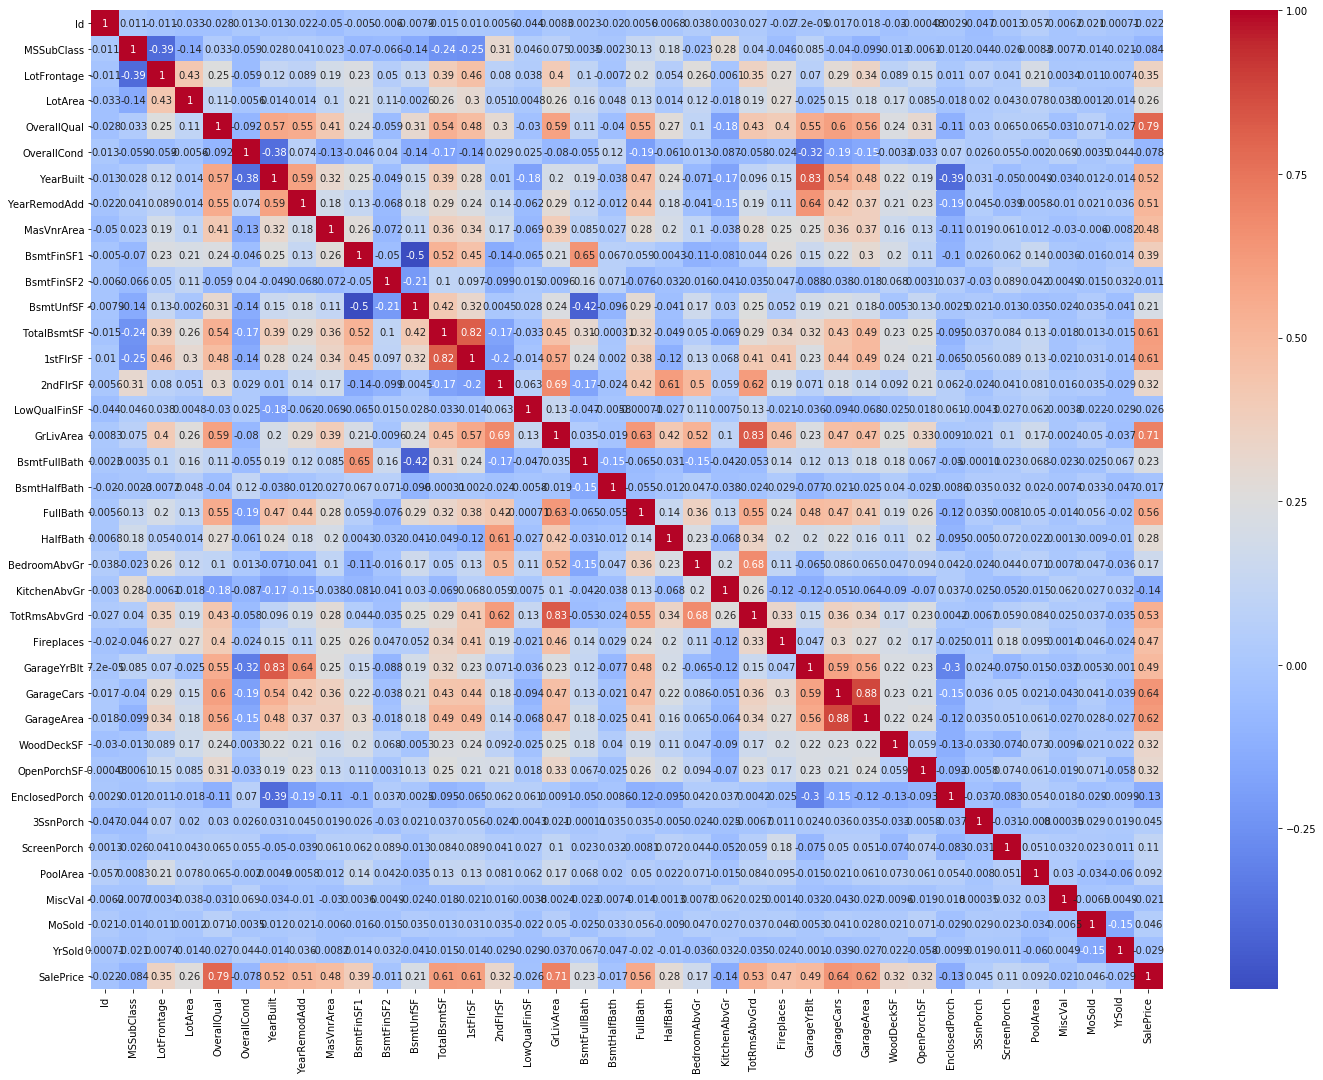

In [32]:
dfVis = df.select_dtypes(exclude=['object'])
plt.figure(figsize=(24, 18))
sns.heatmap(dfVis.corr(),
            annot = True,
           cmap = 'coolwarm')

In [5]:
# Most correlated variables with saleprice such that they are >=abs(0.5):
# Pos: OverallQual, YearBuilt, YearRemodAdd,TotalBsmtSF, 1stFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, GarageCars, GarageArea

# >= 0.4 <=0.5:
# MasVnrArea, Fireplaces, GarageYrBlt

In [33]:
contVars = np.empty(len(list(dfVis)),dtype=object)
for i in range(len(list(dfVis.corr().iloc[0]))):
    corrWithResponse = dfVis.corr().iloc[i][-1]
    if corrWithResponse > 0.25:
        contVars[i] = list(dfVis)[i]

dfVis.corr().iloc[0][-1]

-0.021916719443431112

In [34]:
contVars = contVars[contVars != None]
dfVis = dfVis[contVars]

***
## __Data Preprocessing__
***

In [35]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [36]:
Qualitative_df = df.select_dtypes(exclude=['int64','float64'])

In [37]:
df = pd.concat([dfVis,Qualitative_df],axis=1)

In [38]:
# Count the number of instances of a particular qualitative variable
df['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [39]:
# Removes rows for instances where a column has an entry with only 1 observation of a certain
# qualitative type.
for factor in Qualitative_df:
    df = df[df[factor].duplicated(keep=False)]

In [40]:
df.shape

(1439, 64)

In [41]:
# Drop ID and Utilities because Utilities has not variability.
df = df.drop(['Utilities'],axis=1)

In [42]:
# Create the design matrix and response vector.
X = df.drop(['SalePrice'],axis=1)
y = df['SalePrice']

In [43]:
# OneHotEncoding the qualitative variables as necessary. This is the automatic way. I might need to manually remove some variables later.
X = pd.get_dummies(X,dtype=np.str)

In [44]:
X.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,2003,2003,

In [46]:
# Getting the variable names for later interpretation
predictorVarNames = list(X)

In [47]:
X = X.dropna(axis=1)
X_continuous = X.select_dtypes(exclude=['object'])
#X_continuous = X_continuous.drop(['index'],axis=1)
#polyFeatures = PolynomialFeatures(degree=1)
#polyFeatures.fit_transform(X_continuous)

polyFeatures = PolynomialFeatures(degree=2)
contFeatures = polyFeatures.fit_transform(X_continuous)
contFeatures.shape

(1439, 171)

In [48]:
a  = X.select_dtypes(exclude=['int64','float64'])
b = contFeatures

X = np.hstack((a,b))

In [49]:
X.shape

(1439, 401)

In [50]:
X[X=='']=0

In [51]:
X

array([[0, 0, 0, ..., 0.0, 0.0, 3721.0],
       [0, 0, 0, ..., 88804.0, 0.0, 0.0],
       [0, 0, 0, ..., 0.0, 0.0, 1764.0],
       ...,
       [0, 0, 0, ..., 0.0, 0.0, 3600.0],
       [0, 0, 0, ..., 133956.0, 0.0, 0.0],
       [0, 0, 0, ..., 541696.0, 50048.0, 4624.0]], dtype=object)

In [52]:
# Train/test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=55)

In [53]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400
0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,8712,5,1957,2000,860,992,1306,0,1306,1,0,5,0,1,756,0,0,7.58989e+07,43560,1.70494e+07,1.7424e+07,7.49232e+06,8.6423e+06,1.13779e+07,0,1.13779e+07,8712,0,43560,0,8712,6.58627e+06,0,0,25,9785,10000,4300,4960,6530,0,6530,5,0,25,0,5,3780,0,0,3.82985e+06,3.914e+06,1.68302e+06,1.94134e+06,2.55584e+06,0,2.55584e+06,1957,0,9785,0,1957,1.47949e+06,0,0,4e+06,1.72e+06,1.984e+06,2.612e+06,0,2.612e+06,2000,0,10000,0,2000,1.512e+06,0,0,739600,853120,1.12316e+06,0,1.12316e+06,860,0,4300,0,860,650160,0,0,984064,1.29555e+06,0,1.29555e+06,992,0,4960,0,992,749952,0,0,1.70564e+06,0,1.70564e+06,1306,0,6530,0,1306,987336,0,0,0,0,0,0,0,0,0,0,0,0,1.70564e+06,1306,0,6530,0,1306,987336,0,0,1,0,5,0,1,756,0,0,0,0,0,0,0,0,0,25,0,5,3780,0,0,0,0,0,0,0,1,756,0,0,571536,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,7540,6,1978,1978,773,888,912,0,912,1,0,5,1,2,470,0,0,5.68516e+07,45240,1.49141e+07,1.49141e+07,5.82842e+06,6.69552e+06,6.87648e+06,0,6.87648e+06,7540,0,37700,7540,15080,3.5438e+06,0,0,36,11868,11868,4638,5328,5472,0,5472,6,0,30,6,12,2820,0,0,3.91248e+06,3.91248e+06,1.52899e+06,1.75646e+06,1.80394e+06,0,1.80394e+06,1978,0,9890,1978,3956,929660,0,0,3.91248e+06,1.52899e+06,1.75646e+06,1.80394e+06,0,1.80394e+06,1978,0,9890,1978,3956,929660,0,0,597529,686424,704976,0,704976,773,0,3865,773,1546,363310,0,0,788544,809856,0,809856,888,0,4440,888,1776,417360,0,0,831744,0,831744,912,0,4560,912,1824,428640,0,0,0,0,0,0,0,0,0,0,0,0,831744,912,0,4560,912,1824,428640,0,0,1,0,5,1,2,470,0,0,0,0,0,0,0,0,0,25,5,10,2350,0,0,1,2,470,0,0,4,940,0,0,220900,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,

***
## __Statistical Modeling__
***

In [54]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
# Demonstrating the MAE for this predictive model with all features included.
np.median(lr.predict(X_test) - y_test)

-1794.7773692794144

TypeError: unsupported operand type(s) for +: 'int' and 'str'